In [1]:
import json, os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dir = '/home/jason/Desktop/data/ImageNet-1K/train'
val_dir = '/home/jason/Desktop/data/ImageNet-1K/val'
npys_dir = './npys'

class_json = './ImageNet_class_index.json'

In [3]:
num2class, class2num = {}, {}

with open(class_json) as json_file:
    json_data = json.load(json_file)
    for num in json_data:
        num2class[int(num)] = json_data[num][-1]
        class2num[json_data[num][-1]] = int(num)

In [4]:
train_imgs = []
train_info = {i:0 for i in range(1000)}

for label in sorted(os.listdir(train_dir)):
    if label.isnumeric():
        label_dir = os.path.join(train_dir, label)
        for img in sorted(os.listdir(label_dir)):
            if img.endswith('.JPEG'):
                img_dir = os.path.join(label_dir, img)
                train_imgs.append(img_dir)
                train_info[int(label)] += 1

In [5]:
train_npys_dir = {}

for file in sorted(os.listdir(npys_dir)):
    if file.endswith('train.npy'):
        _, e, _, _ = file.split('_')
        if e not in train_npys_dir:
            train_npys_dir[e] = []
        
        train_npys_dir[e].append(os.path.join(npys_dir, file))

In [6]:
train_events = {}

for epoch in train_npys_dir:
    print(epoch)
    train_events[epoch] = {}
    for npy_dir in train_npys_dir[epoch]:
        print(npy_dir)
        npy = np.load(npy_dir)
        for i in range(npy.shape[0]):
            img = train_imgs[i]
            if img not in train_events[epoch]:
                train_events[epoch][img] = {'first_learning_event' : [], 'forgetting_event' : []}

            img_event = npy[i]
            img_event = ''.join(map(str, img_event.tolist()))

            if '1' in img_event:
                train_events[epoch][img]['first_learning_event'].append(1 + img_event.index('1'))
            else:
                train_events[epoch][img]['first_learning_event'].append(-1)

            train_events[epoch][img]['forgetting_event'].append(img_event.count('10'))
    print()

015
./npys/ResNet50_015_00_train.npy

040
./npys/ResNet50_040_00_train.npy

060
./npys/ResNet50_060_00_train.npy



In [7]:
first_learn_epochs = {}
forget_counts = {}

for epoch in train_events:
    first_learn_epochs[epoch] = {}
    forget_counts[epoch] = {}
    for img_dir in train_events[epoch]:
        first_learn_epoch = train_events[epoch][img_dir]['first_learning_event'][0]
        forget_count = train_events[epoch][img_dir]['forgetting_event'][0]
        
        if first_learn_epoch not in first_learn_epochs[epoch]: first_learn_epochs[epoch][first_learn_epoch] = 0
        if forget_count not in forget_counts[epoch]: forget_counts[epoch][forget_count] = 0
            
        first_learn_epochs[epoch][first_learn_epoch] += 1
        forget_counts[epoch][forget_count] += 1

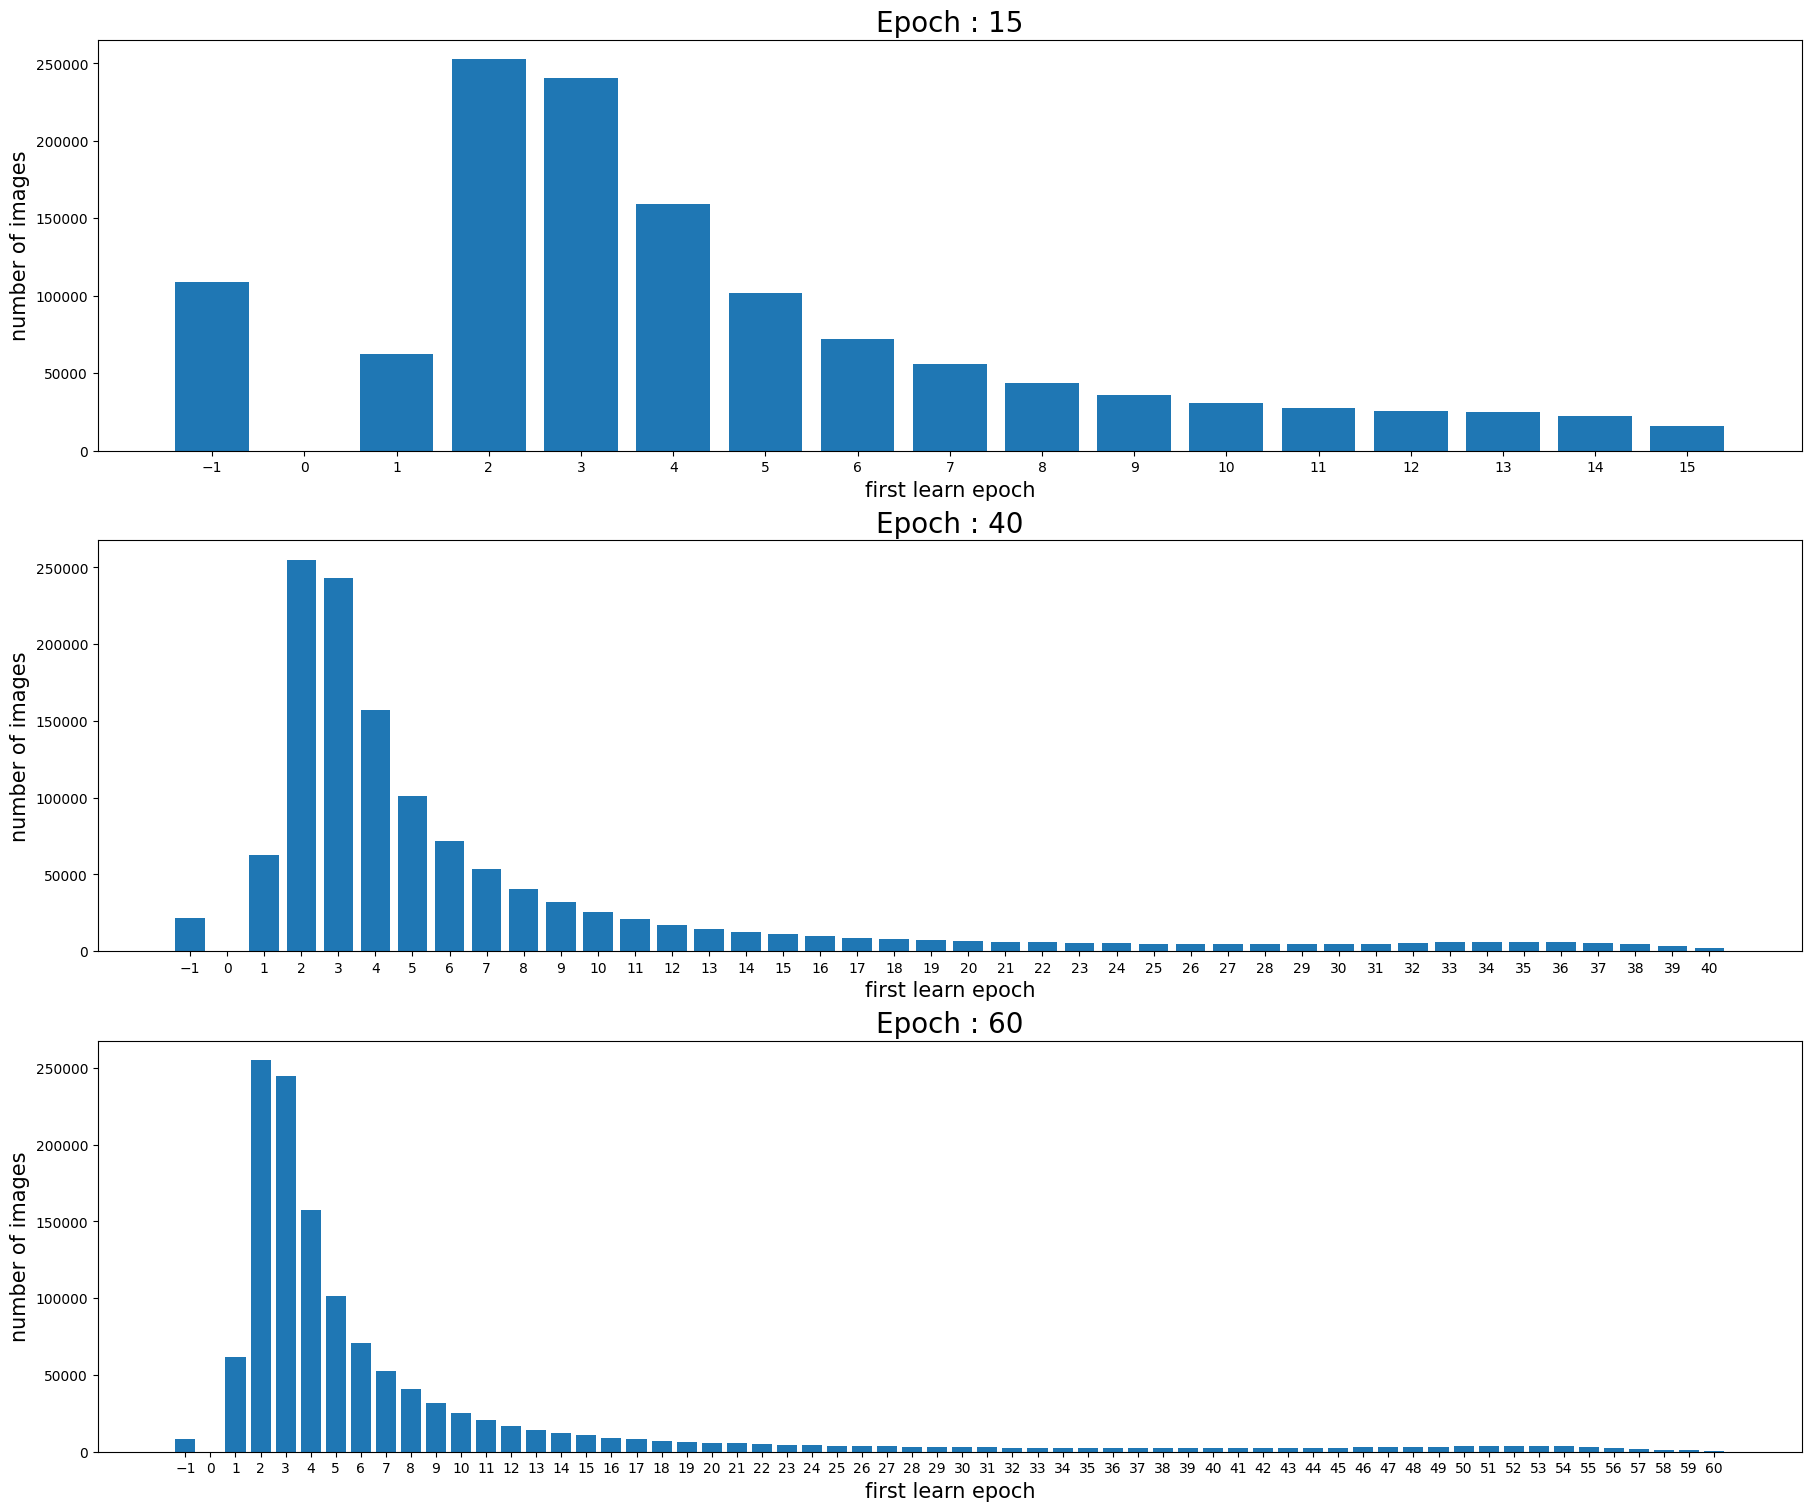

In [8]:
fig, axs = plt.subplots(len(first_learn_epochs), 1, figsize=(18, 15), constrained_layout=True)

for i, epoch in enumerate(first_learn_epochs):
    axs[i].bar(*zip(*first_learn_epochs[epoch].items()), align='center')
    axs[i].set_title('Epoch : {}'.format(int(epoch)), fontsize=20)
    axs[i].set_xlabel('first learn epoch', fontsize=15)
    axs[i].set_ylabel('number of images', fontsize=15)
    axs[i].set_xticks(np.arange(-1, max(first_learn_epochs[epoch])+1))

plt.show()

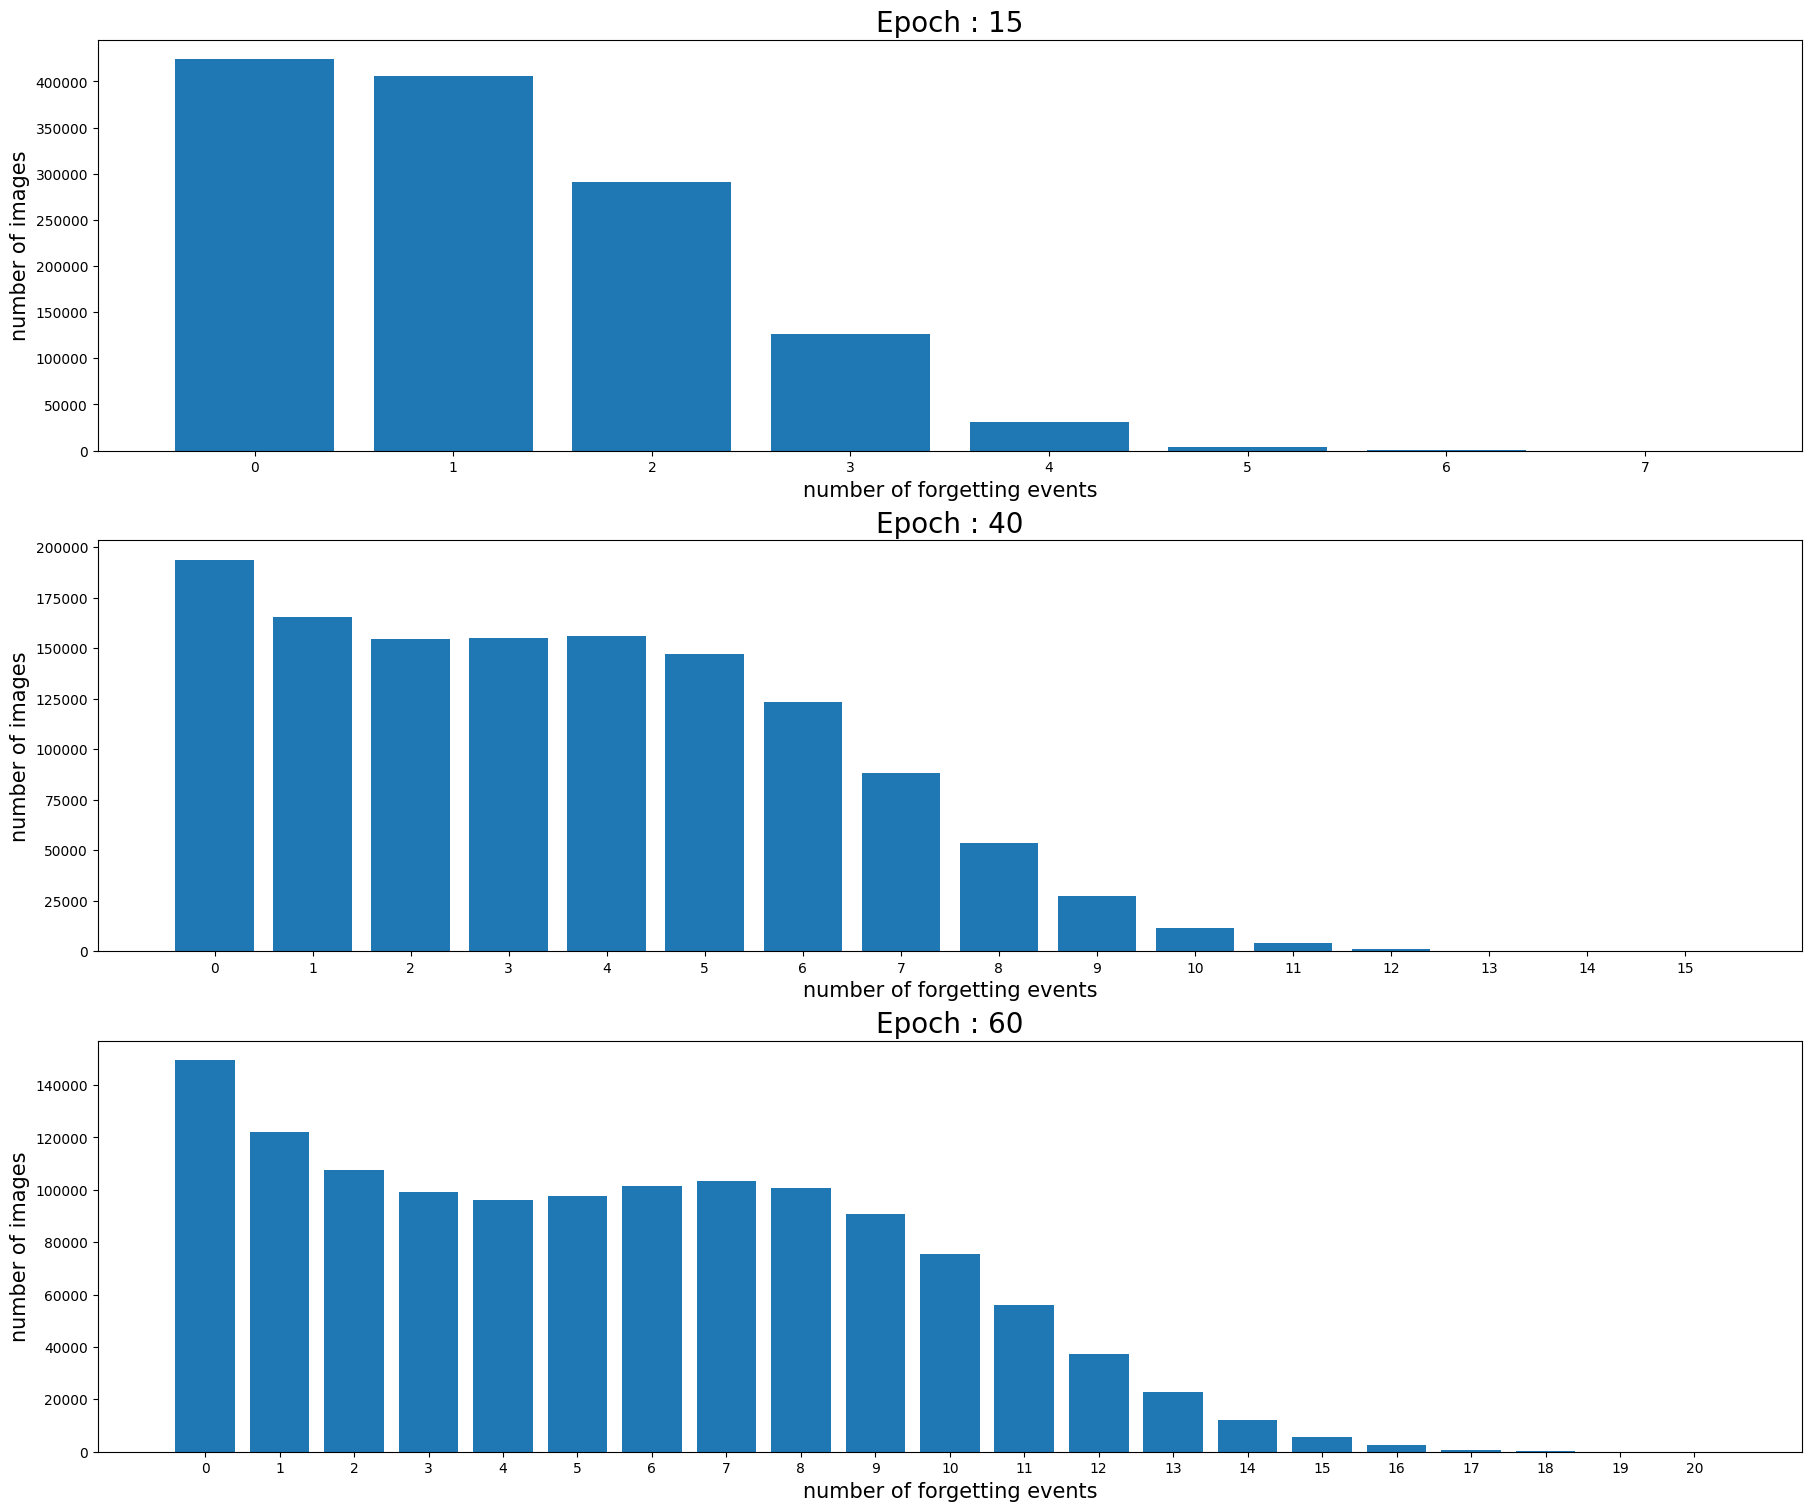

In [9]:
fig, axs = plt.subplots(len(forget_counts), 1, figsize=(18, 15), constrained_layout=True)

for i, epoch in enumerate(forget_counts):
    axs[i].bar(*zip(*forget_counts[epoch].items()), align='center')
    axs[i].set_title('Epoch : {}'.format(int(epoch)), fontsize=20)
    axs[i].set_xlabel('number of forgetting events', fontsize=15)
    axs[i].set_ylabel('number of images', fontsize=15)
    axs[i].set_xticks(np.arange(max(forget_counts[epoch])+1))

plt.show()

In [10]:
# train imgs not learned by model

for epoch in train_events:
    print(epoch)
    dic = {num2class[i] : [] for i in range(1000)}
    for img in train_events[epoch]:
        img_label = int(img.split('/')[-2])

        for first_learn in train_events[epoch][img]['first_learning_event']:
            if first_learn != -1:
                break
        else:
            dic[num2class[img_label]].append(img)
            
    with open('./not_learned_train_{}.json'.format(epoch), 'w') as j:
        json.dump(dic, j, indent=4)

015
040
060
